# `CausalImpact` (in Python)

An approach to estimating the causal effect of a designed intervention on a time series. The goal is to make counterfactual inference as easy as fitting a regression model, but much more powerful, provided some assumptions are met (see _Model Assumptions_).

Given a response time series (e.g., clicks) and a set of control time series (e.g., clicks in non-affected markets or clicks on other sites), the package constructs a _Bayesian structural time-series model_. This model is then used to try and predict the _counterfactual_, i.e., how the response metric would have evolved after the intervention if the intervention had never occurred.

# Setup

In [1]:
import causalimpact as ci
import numpy as np
import pandas as pd
import seaborn as sns

## Generating Auto-Regressive Data

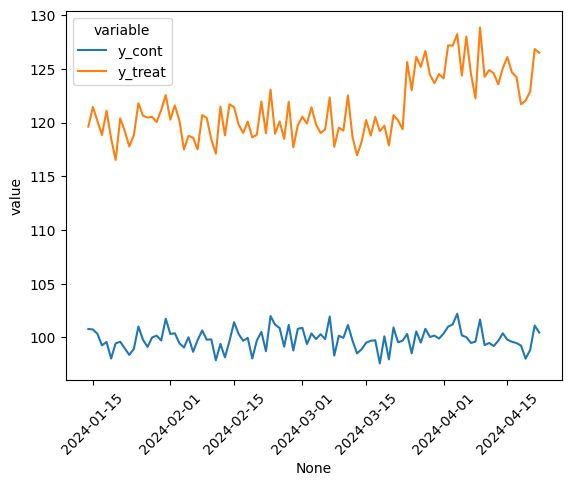

In [2]:
import statsmodels.tsa.arima_process as arima
from datetime import date, timedelta

#Params
days=100
shock_period=70

#Generate data
y_cont = 100 + arima.ArmaProcess(ar=0.999, ma=1).generate_sample(nsample=days)
y_treat = 1.2*y_cont + np.random.normal(size=days)
y_treat[shock_period:] = y_treat[shock_period:] + 5 #Shock!
dates = pd.date_range(date.today() - timedelta(days=(days-1)), periods=days)
exp_df = pd.DataFrame({
                     'y_cont':y_cont 
                     , 'y_treat':y_treat}
                     , index=dates)
exp_df_melt = pd.melt(exp_df, ignore_index=False)

#Plot AR data
g = sns.lineplot(x=exp_df_melt.index, y='value', hue='variable'
             , data=exp_df_melt)
g.tick_params(axis='x', rotation=45)


# Running an Analysis

## Set Periods 

The first step is to specify which period of data should be used for training the model (i.e., the _pre-intervention period_), and which period for computing the counter-factual prediction (i.e., the _post-intervention_ period).

In [3]:
import datetime as dt

training_start = exp_df.index[0]
training_end = exp_df.index[shock_period - 2]
treatment_start = exp_df.index[shock_period - 1]
treatment_end = exp_df.index[-1]
pre_period = [training_start, training_end]
print("Pre-period: " + str([str(d) for d in pre_period]))
post_period = [treatment_start, treatment_end]
print("Post-period: " + str([str(d) for d in post_period]))

Pre-period: ['2024-01-14 00:00:00', '2024-03-22 00:00:00']
Post-period: ['2024-03-23 00:00:00', '2024-04-22 00:00:00']


## Go-go Gadget CausalImpact!

In [5]:
import sys
!{sys.executable} -m pip list | grep 'causalimpact'

tfp-causalimpact             0.2.0


In [4]:
#[['y_cont', 'y_treat']]

impact = ci.fit_causalimpact(
    data=exp_df
    , pre_period=pre_period
    , post_period=post_period
)

AttributeError: module 'causalimpact' has no attribute 'fit_causalimpact'

## Model Assumptions

As with all non-experimental approaches to causal inference, valid conclusions require strong assumptions. In the case of CausalImpact, we assume:

1. That there is a set control time series that were _not affected by the intervention_. If they were, we might falsely under or over-estimate the true effect. Or we might falsely conclude that there was an effect even though in reality there was not.
2. The model also assumes that the relationship between covariates and treated time series, as established during the pre-period, remains stable throughout the post-period (see _dynamic regression_ for a means of relaxing this assumption).
3. Awareness of priors that affect the relationship between the outcome and the related covariates.

# Acks & Refs

- `CausalImpact`'s R Page: [https://google.github.io/CausalImpact/CausalImpact.html](https://google.github.io/CausalImpact/CausalImpact.html)
- Kay H. Brodersen's Demo - [Inferring the effect of an event using `CausalImpact`](https://youtu.be/GTgZfCltMm8)
- [Inferring causal impact using Bayesian structural time-series models](https://research.google/pubs/inferring-causal-impact-using-bayesian-structural-time-series-models/) - Brodersen et al. - Peer Reviewed Paper published in the Annals of Applied Statistics